In [1]:
import numpy as np
import gpmp.num as gnp
import gpmp as gp
import matplotlib.pyplot as plt

Using backend: torch


# Parameters

In [2]:
case_name                   = "wave"
N_function_points           = [80, 80]
N_observed_points           = 25
observed_points_design_type = "ld"
mu0                         = 0
p                           = 6
nugget                      = 1e-12
meanparam                   = np.array([mu0])

# Functions

In [3]:
def generate_data(case_name, N_function_points, N_observed_points, observed_points_design_type):
    if case_name   == "braninhoo":
        f                 = gp.misc.testfunctions.braninhoo
        box               = [[-5, 0], [10, 15]]
    elif case_name == "wave":
        f                 = gp.misc.testfunctions.wave
        box               = [[-1, -1], [1, 1]]
    input_dimension       = 2
    x_function_points     = gp.misc.designs.regulargrid(input_dimension, N_function_points, box)
    y_function_points     = f(x_function_points)
    if observed_points_design_type   == "lhs":
        x_observed_points = gp.misc.designs.maximinlhs(input_dimension, N_observed_points, box)
    elif observed_points_design_type == "ld":
        x_observed_points = gp.misc.designs.ldrandunif(input_dimension, N_observed_points, box)
    y_observed_points     = f(x_observed_points)
    return x_function_points, y_function_points, x_observed_points, y_observed_points, box

In [4]:
def constant_mean(x, meanparam):
    return meanparam[0] * gnp.ones((x.shape[0], 1))

In [5]:
def kernel(x, y, covparam, pairwise=False):
    return gp.kernel.maternp_covariance(x, y, p, covparam, pairwise, nugget)

In [6]:
def visualize_results(x_function_points, y_function_points, x_observed_points, y_observed_points, y_posterior_mean, y_posterior_variance, N_function_points, N_observed_points, box):
    cmap          = plt.get_cmap('PiYG')
    contour_lines = 30
    fig, axes     = plt.subplots(nrows=2, ncols=2)
    data          = [y_function_points, y_posterior_mean, np.abs(y_posterior_mean - y_function_points), np.sqrt(y_posterior_variance)]
    titles        = ['function to be approximated', f'approximation from {len(x_observed_points)} points', 'true approx error', 'posterior std']
    for ax, y, title in zip(axes.flat, data, titles):
        cs        = ax.contourf(x_function_points[:, 0].reshape(N_function_points), x_function_points[:, 1].reshape(N_function_points), y.reshape(N_function_points), levels=contour_lines, cmap=cmap)
        ax.plot(x_observed_points[:, 0], x_observed_points[:, 1], 'ro', label='data')
        ax.set_title(title)
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.legend()
        fig.colorbar(cs, ax=ax, shrink=0.9)
    plt.show()
    # Predictions vs truth
    plt.figure()
    plt.plot(y_function_points, y_posterior_mean, 'ko')
    (xmin, xmax), (ymin, ymax) = plt.xlim(), plt.ylim()
    xmin = min(xmin, ymin)
    xmax = max(xmax, ymax)
    plt.plot([xmin, xmax], [xmin, xmax], '--')
    plt.xlabel('true values')
    plt.ylabel('predictions')
    plt.show()
    # LOO predictions
    zloom, zloov, eloo = model.loo(x_observed_points, y_observed_points)
    gp.misc.plotutils.plot_loo(y_observed_points, zloom, zloov)
    gp.misc.plotutils.crosssections(model, x_observed_points, y_observed_points, box, [0, N_observed_points-1], [0, 1])

# Points generation

In [7]:
x_function_points, y_function_points, x_observed_points, y_observed_points, box = generate_data(case_name, N_function_points, N_observed_points, observed_points_design_type)

# Gaussian process 2D regression with GPMP

In [8]:
model                                  = gp.core.Model(constant_mean, kernel, meanparam, meantype="parameterized")
model, info                            = gp.kernel.select_parameters_with_reml(model, x_observed_points, y_observed_points, info=True)
covparam0                              = gp.kernel.anisotropic_parameters_initial_guess(model, x_observed_points, y_observed_points)
nlrl, dnlrl                            = gp.kernel.make_selection_criterion_with_gradient(model.negative_log_likelihood_zero_mean, x_observed_points, y_observed_points)
covparam_reml, info2                   = gp.kernel.autoselect_parameters(covparam0, nlrl, dnlrl, info=True)
model.covparam                         = gnp.asarray(covparam_reml)
y_posterior_mean, y_posterior_variance = model.predict(x_observed_points, y_observed_points, x_function_points)

In [9]:
print(np.exp(0.5*covparam_reml[0]), np.exp(-covparam_reml[1]), np.exp(-covparam_reml[2]))

16.62184725216976 0.4287518925668946 2.386316620370885


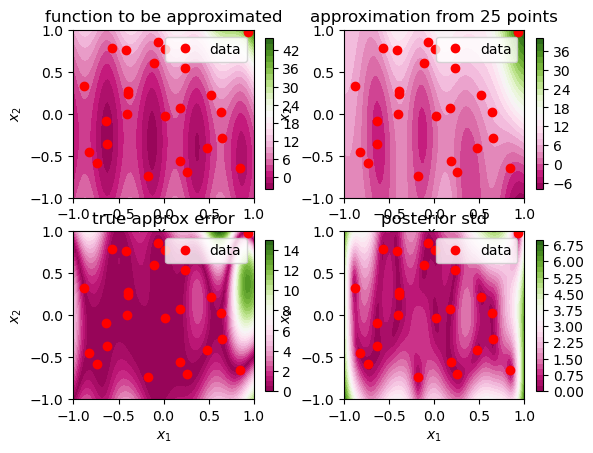

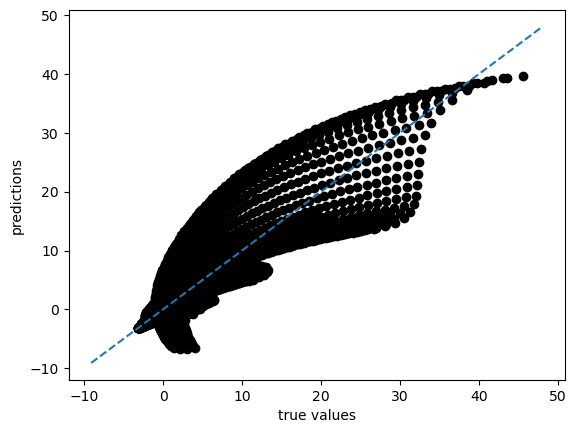

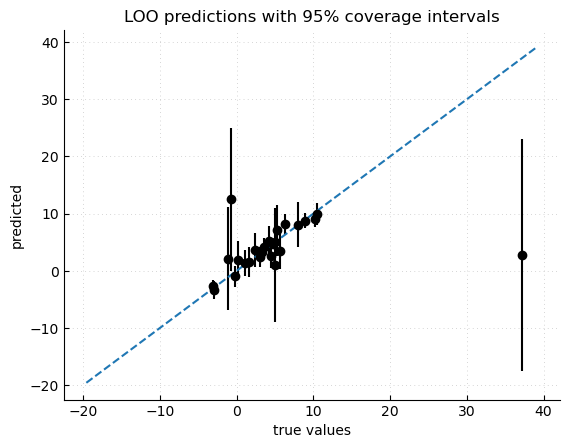

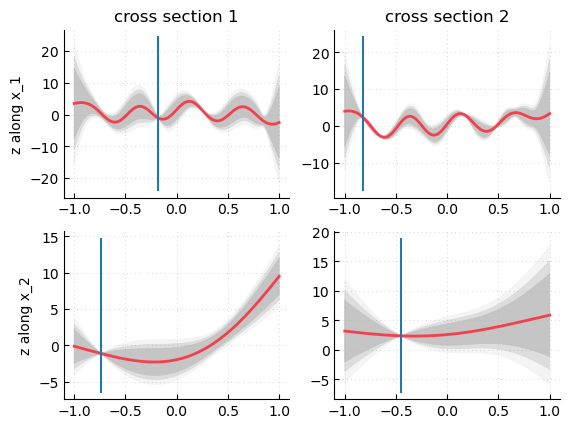

In [10]:
visualize_results(x_function_points, y_function_points, x_observed_points, y_observed_points, y_posterior_mean, y_posterior_variance, N_function_points, N_observed_points, box)

# Gaussian process 2D regression with custom class

In [11]:
import sys 
sys.path.append("C:/Users/L2S/Desktop/Efficient_and_reliable_GP/")

from Code.gaussian_processes.gaussian_process            import GaussianProcessModel
from Code.Parameters        .gaussian_process_parameters import gaussian_process_model_parameters

In [12]:
gaussian_process_model_parameters["Mean initialization method"] = "Fixed"
gaussian_process_model_parameters["Default mean parameter"    ] = mu0
gaussian_process_model_parameters["Nugget"                    ] = nugget
gaussian_process_model_parameters["Matern parameter"          ] = p

In [13]:
gaussian_process_model                 = GaussianProcessModel(x_observed_points, y_observed_points, gaussian_process_model_parameters)
gaussian_process_model.train()
hyperparameters                        = gaussian_process_model.get_hyperparameters() 
y_posterior_mean, y_posterior_variance = gaussian_process_model.predict(x_function_points)

In [14]:
hyperparameters

{'Time': 0.16059255599975586,
 'p': 6,
 'mu': 0,
 'sigma': 16.621847156083916,
 'Length scales': [0.4287518916143542, 2.3863166690179423],
 'Nugget': 1e-12}

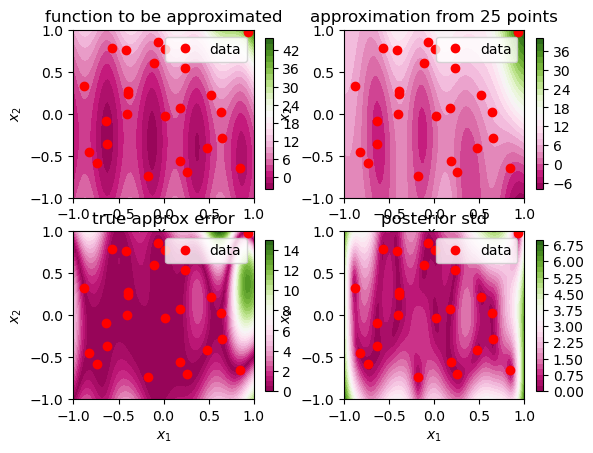

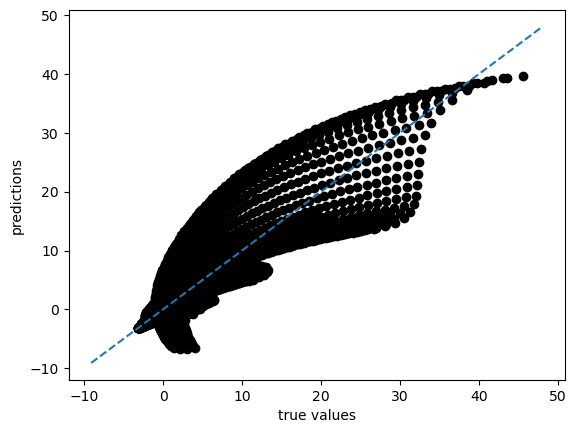

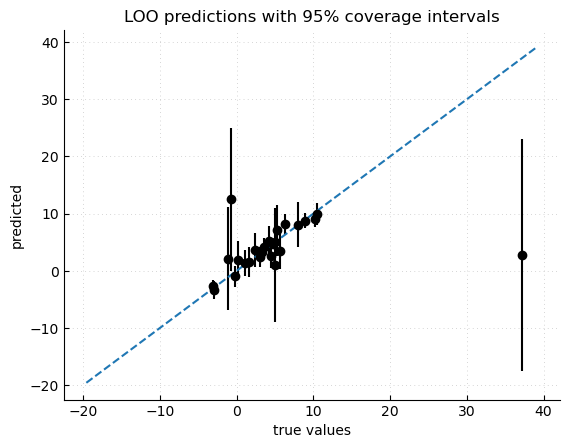

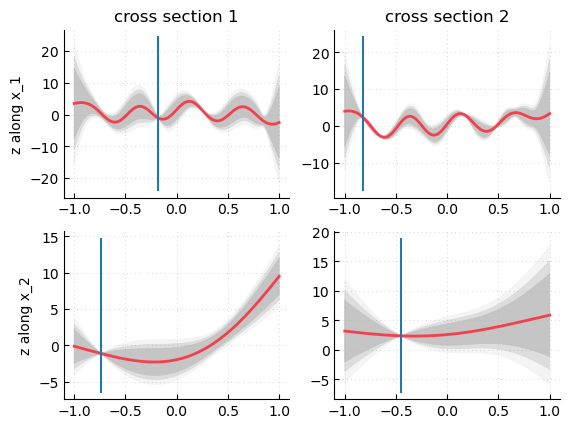

In [15]:
visualize_results(x_function_points, y_function_points, x_observed_points, y_observed_points, y_posterior_mean, y_posterior_variance, N_function_points, N_observed_points, box)